## Detection of monosynapic connections
A major advantage of single unit recordings is that we can detect if they are synaptically connected. There is a well-established procedure for assessing a single synaptic linkage from one neuron onto another, referred to as a monosynaptic connection. Polysynaptic connections, whereby one neuron influences another via a chain of synapses, is harder to detect if we have not recorded from the entire chain. However, if enough neurons are sampled from complex networks of connections can be uncovered and related back to what these neurons encode. This indicates how a microcircuit's structure implements function.

This tutorial covers the detection of monosynaptic connections and creation of a connection matrix.

In [2]:
import pynapple as nap
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mimo_pack.fileio.loadphy import as_pynapple

### Load spiking data

In [2]:
phy_dir = 'D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\kilosort4\\'
spks = as_pynapple(phy_dir, suffix='_sas')

           SASLabel
cluster_id         
0             Noise
1                SU
2                SU
3                MU
4                MU
...             ...
766              SU
767              SU
768              MU
769              MU
770              SU

[701 rows x 1 columns]


QA on units. To start, just remove those that are not SU

In [3]:
spks = spks.getby_category('SASLabel')['SU']


### Calculate cross-correlation
To determine if a monosynaptic connection is present, we calculate the cross-correlation between single units. One of the units is designated the reference and the other the target. A histogram is constructed of the spike times from the target with respect to the spike times of the reference. If there is an excess of target spikes following a spike from the reference, this could indicate an excitatory synaptic connection.

The pynapple package provides an optimized algorithm for calculating cross-correlation functions.

In [4]:
bin_dur = 0.0005 # in seconds, 0.5 ms
win_dur = 0.01 # in seconds, 10 ms

cc_func = lambda x: nap.compute_crosscorrelogram(x,binsize=bin_dur,windowsize=win_dur,reverse=True)
spks_cc = cc_func(spks)

Pynapple returns the CC as a dataframe like object with each row a different time point, and each column a unique pair. A multilevel index is used for accessing the pairs. It is expressed as a tuple of 2 values, with form *(reference, target)*. Reference is the unit who spikes at time 0 ms, while target is the unit whose firing rate is being calculated relative to the spiking of the reference unit.

Here is how to pull out information from the cross-correlation object returned by pynapple:

In [5]:
# Get the time points of the CC
cc_tpts = spks_cc.index.values
print('The time points look like this:\n{}'.format(cc_tpts))

The time points look like this:
[-0.01   -0.0095 -0.009  -0.0085 -0.008  -0.0075 -0.007  -0.0065 -0.006
 -0.0055 -0.005  -0.0045 -0.004  -0.0035 -0.003  -0.0025 -0.002  -0.0015
 -0.001  -0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003
  0.0035  0.004   0.0045  0.005   0.0055  0.006   0.0065  0.007   0.0075
  0.008   0.0085  0.009   0.0095  0.01  ]


In [6]:
# List all the pairs
cc_pairs = spks_cc.columns.values.tolist()

print('Number of pairs: {}'.format(len(cc_pairs)))

Number of pairs: 43071


### Examine CCs
Cross-correlation fuctions are often visualized as bar charts. Learning how to interpret these is an essential skill for an electrophysiologist.

In [7]:
# function to plot a cross-correlation
def cc_plot(cc, ax=None, labels=True): 
    # cc is a series selected from spks_cc, e.g. spks_cc[(0,1)] for the cc between unit 0 and 1
    t_pts = cc.index.values*1000
    cc_vals = cc.values
    dt = t_pts[1]-t_pts[0]
    if ax is None:
        fig, ax = plt.subplots()
    ax.grid()
    ax.bar(t_pts,cc_vals,width=dt,bottom=0)
    ax.set_xlim((t_pts[0],t_pts[-1]))
    ax.set_title(cc.name)
    if labels:
        ax.set_xlabel('Time from reference spike (ms)')
        ax.set_ylabel('Normalized FR (FR / mean_FR)')
    return ax

Here we will plot a few example pairs that highlight how to interpret CC.

c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


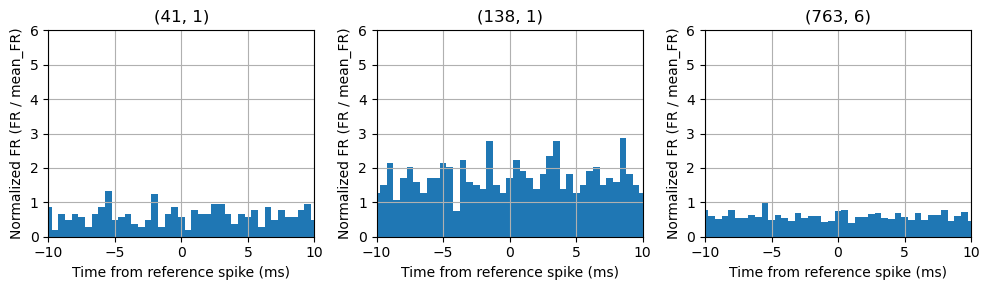

In [8]:
# Monosynaptic CCs vs non-monosynaptic CCs
fig, ax = plt.subplots(1,3)
cc_plot(spks_cc[cc_pairs[11]],ax=ax[0])
cc_plot(spks_cc[cc_pairs[44]],ax=ax[1])
cc_plot(spks_cc[cc_pairs[1160]],ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()

### Statistical testing of connections
A common, but computationally expensive, approach to testing the significance of monosynaptic CCs is to calculate surrogates using randomly jittered spike trains. To jitter, shift each spike in time by a random amount. If you jitter the spike times in a window of ~2 ms, calculate its CC with another unit, and repeat this thousands of times, you get a distribution of CCs that capture slow covarition in spiking activity, but eliminates fast interactions like those found between monosynaptically connected pairs. Using this distribution of CCs, you can measure the probability that the observed CC would have occured. If that probability is below some cutoff, say 0.01, then the CC is judged significant.

In [9]:
jit_max = 0.002 # in seconds, 2 ms
jit_num = 100 # number of jittered CCs to calculate 
cc_null_dist = np.zeros((*spks_cc.values.shape, jit_num))

for i in tqdm(range(jit_num)):
    # kept tsupport only because end of session is 'blank'
    spks_jit = nap.jitter_timestamps(spks, max_jitter=jit_max,keep_tsupport=True)
    spks_cc_jit = cc_func(spks_jit)
    cc_null_dist[:,:,i] = spks_cc_jit.values

null_ci = np.percentile(cc_null_dist,q=[0.5,50,99.5],axis=2)

100%|██████████| 100/100 [9:12:44<00:00, 331.64s/it] 


In [15]:
# function to plot cross-correlation with null confidence intervals
def cc_ci_plot(cc, ci, **kwargs):
    curr_ci = null_ci[:,:,cc_pairs.index(cc.name)]
    t_pts = cc.index.values*1000
    ax = cc_plot(cc, **kwargs)
    ax.fill_between(t_pts,curr_ci[0,:],curr_ci[2,:],alpha=0.2,color='k')
    ax.plot(t_pts,curr_ci[1,:],color='k',linestyle=':')
    ax.plot(t_pts,curr_ci[0,:],color='b',alpha=0.7)
    ax.plot(t_pts,curr_ci[2,:],color='r',alpha=0.7)


Let's replot the CCs from above, but now with the confidence intervals for our surrogate distributions overlaid on top.

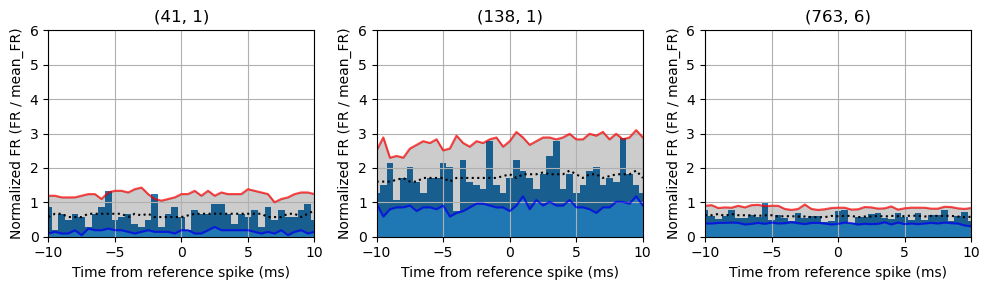

In [16]:
# Monosynaptic CCs vs non-monosynaptic CCs
fig, ax = plt.subplots(1,3)
cc_ci_plot(spks_cc[cc_pairs[11]],null_ci,ax=ax[0])
cc_ci_plot(spks_cc[cc_pairs[44]],null_ci,ax=ax[1])
cc_ci_plot(spks_cc[cc_pairs[1160]],null_ci,ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()


### Building a connection matrix

In [17]:
# determine if CC is significant and its weight
def cc_sig(cc_vals, cc_ci):
    # cc_vals is half the cc (pos or neg lag side), and always starts at 0 lag
    # cc_ci is the lower, middle, and upper null percentiles for the corresponding cc_vals
    cc_dev = cc_vals-cc_ci[1,:]
    max_ind = np.argmax(np.abs(cc_dev))

    # determine if maximal deviation is significant
    if cc_vals[max_ind]>cc_ci[2,max_ind]:
        cc_dev_sig = (cc_vals-cc_ci[2,:])>0
    elif cc_vals[max_ind]<cc_ci[0,max_ind]:
        cc_dev_sig = (cc_vals-cc_ci[0,:])<0
    else:
        return 0 # exit if max deviation is within null CI

    # determine if maximal deviation does not overlap zero lag and is long enough
    # get left edge of significant region
    l_edge = max_ind
    for x in range(max_ind,0,-1):
        l_edge = x
        if not cc_dev_sig[x-1]:
            break
    
    # get right edge of significant region
    r_edge = max_ind
    for x in range(max_ind,cc_vals.size-1):
        r_edge = x
        if not cc_dev_sig[x+1]:
            break
    
    # if sig peak overlaps with 0 time lag, then no connection
    if l_edge == 0:
        return 0

    
    # if sig peak is shorter than 1ms or longer than 4 ms, then no connection
    peak_dur = ((r_edge-l_edge)+1)*bin_dur
    if (peak_dur<0.001) or (peak_dur>0.004):
        return 0
    
    # connection passed all tests and is significant, return weight
    return 100*cc_dev[max_ind]/cc_ci[1,max_ind]


In [18]:
# create connection matrix
num_units = len(spks)

# list all unit ids
conn_mat = pd.DataFrame(np.zeros((num_units, num_units)), index=spks.index, columns=spks.index)
sig_dict = {'pre_id': [], 'post_id': [], 'w': [], 'cc': []}


for ind, pair in enumerate(cc_pairs):
    curr_ci = null_ci[:,:,ind]
    curr_cc = spks_cc[pair]
    z_lag_ind = np.argmin(np.abs(curr_cc.index.values)) # found closest to zero in case lag not exactly zero

    # evaluate positive lag, reference -> target
    w_r2t = cc_sig(curr_cc.values[z_lag_ind:], curr_ci[:,z_lag_ind:])
    conn_mat.loc[pair[0],pair[1]] = w_r2t
    sig_dict['pre_id'].append(pair[0])
    sig_dict['post_id'].append(pair[1])
    sig_dict['w'].append(w_r2t)
    sig_dict['cc'].append(curr_cc.values)
    

    # evaluate negative lag, target -> reference
    w_t2r = cc_sig(curr_cc.values[z_lag_ind::-1], curr_ci[:,z_lag_ind::-1])
    conn_mat.loc[pair[1],pair[0]] = w_t2r
    sig_dict['pre_id'].append(pair[1])
    sig_dict['post_id'].append(pair[0])
    sig_dict['w'].append(w_t2r)
    sig_dict['cc'].append(curr_cc.values[::-1])


In [20]:
sig_df = pd.DataFrame(sig_dict)
spk_props = pd.read_csv("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\spk_props.csv")
sig_df = sig_df.merge(spk_props.add_suffix('_pre'), left_on='pre_id', right_on='cluster_id_pre')
sig_df = sig_df.merge(spk_props.add_suffix('_post'), left_on='post_id', right_on='cluster_id_post')

In [90]:
sig_df.to_pickle("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\cc.pkl")


,pre_id,post_id,w,cc,cluster_id_pre,halfwidth_pre,firing_rate_pre,peak_pre,x_pre,y_pre,unit_type_pre,cluster_id_post,halfwidth_post,firing_rate_post,peak_post,x_post,y_post,unit_type_post
0,2,1,0.0,"[0.8456689813849999, 0.8879524304542499, 0.782...",2,0.233333,5.659228,-23.013167,27.0,3255.0,RS,1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
1,1,2,0.0,"[0.782243807781125, 0.8668107059196251, 0.5496...",1,0.213333,0.618804,-68.417289,27.0,3225.0,RS,2,0.233333,5.659228,-23.013167,27.0,3255.0,RS
2,5,1,0.0,"[2.269691810555335, 6.809075431666005, 2.26969...",5,0.233333,0.105429,-25.890844,309.0,3240.0,RS,1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
3,1,5,0.0,"[0.0, 4.53938362111067, 2.269691810555335, 5.6...",1,0.213333,0.618804,-68.417289,27.0,3225.0,RS,5,0.233333,0.105429,-25.890844,309.0,3240.0,RS
4,6,1,0.0,"[3.0572673544670947, 1.0190891181556982, 2.547...",6,0.236667,0.234809,-29.162822,309.0,3255.0,RS,1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46867,764,766,0.0,"[1.237983185921388, 1.205784089082594, 1.21875...",764,0.093333,10.124531,-25.581856,809.0,3630.0,FS,766,0.093333,15.216226,-19.022156,809.0,3690.0,FS
46868,770,764,0.0,"[1.131485237249313, 1.1834004422525166, 1.1927...",770,0.086667,5.493459,-31.911500,809.0,3795.0,FS,764,0.093333,10.124531,-25.581856,809.0,3630.0,FS
46869,764,770,0.0,"[1.104862055196388, 1.1128490098122654, 1.1394...",764,0.093333,10.124531,-25.581856,809.0,3630.0,FS,770,0.086667,5.493459,-31.911500,809.0,3795.0,FS
46870,770,766,0.0,"[1.213440506298859, 1.193068877360995, 1.24886...",770,0.086667,5.493459,-31.911500,809.0,3795.0,FS,766,0.093333,15.216226,-19.022156,809.0,3690.0,FS


In [5]:
# read sig_df from pickle
sig_df = pd.read_pickle("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\cc.pkl")

In [6]:
# calculate distance between units
dist_func = lambda x: np.sqrt((x['x_pre']-x['x_post'])**2 + (x['y_pre']-x['y_post'])**2)
sig_df['conn_dist'] = sig_df.apply(dist_func, axis=1)

# categorize distances
def dist_cat_func(dist):
    if dist < 50:
        dist_cat = 25
    elif dist < 100:
        dist_cat = 75
    elif dist < 150:
        dist_cat = 125
    elif dist < 200:
        dist_cat = 175
    else:
        dist_cat = 250
    
    return dist_cat
sig_df['conn_dist_cat'] = sig_df.apply(lambda x: dist_cat_func(x['conn_dist']), axis=1)

# connection type
type_func = lambda x: "{}->{}".format(x['unit_type_pre'], x['unit_type_post'])
sig_df['conn_type'] = sig_df.apply(type_func, axis=1)

# conn sign
sig_df['conn_sign'] = sig_df.apply(lambda x: np.sign(x['w']), axis=1)


In [7]:
# group significant connections into categories
conn_sum = sig_df.groupby(by=['conn_dist_cat', 'conn_type', 'conn_sign'])

# type dataframe
conn_types = conn_sum[['w']].count()

# cc dataframe
# stack ccs into a single array within each group where each row is a cc and each column is a time lag
conn_cc = conn_sum[['cc','pre_id','post_id']].apply(lambda x: np.vstack(x.values))

In [25]:
def cc_dist_percent(conn_df, conn_type, conn_sign):
    conn_tot = conn_df['w'].groupby(['conn_dist_cat', 'conn_type']).sum()
    conn_dist = conn_df.loc[slice(None), conn_type, conn_sign]
    conn_dist = conn_dist.merge(conn_tot.loc[slice(None), conn_type], left_index=True, right_index=True)
    conn_dist['Percent'] = (conn_dist['w_x']/conn_dist['w_y'])*100
    return conn_dist

conn_rsrs = cc_dist_percent(conn_types, 'RS->RS', 1)
conn_rsfs = cc_dist_percent(conn_types, 'RS->FS', 1)
conn_fsrs = cc_dist_percent(conn_types, 'FS->RS', 1)

c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


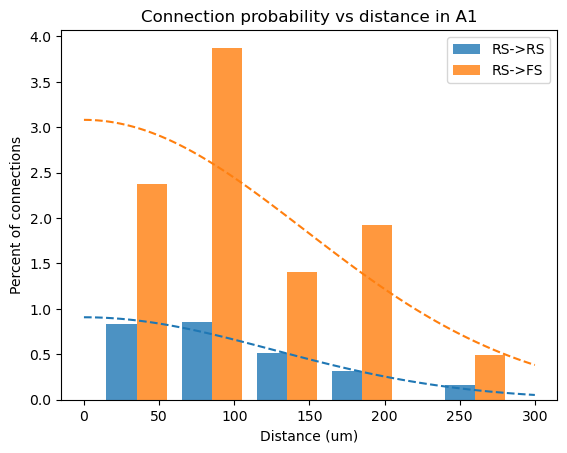

In [26]:
# plot bar graph of both connection types vs distance
fig, ax = plt.subplots()
ax.bar(conn_rsrs.index, conn_rsrs['Percent'].values, width=20, label='RS->RS', alpha=0.8)
ax.bar(conn_rsfs.index+20, conn_rsfs['Percent'].values, width=20, label='RS->FS', alpha=0.8)
ax.legend()
ax.set_xlabel('Distance (um)')
ax.set_ylabel('Percent of connections')
ax.set_title('Connection probability vs distance in A1')

# add half gaussian fitted curves to the bars
from scipy.optimize import curve_fit

def half_gauss(x, a, b):
    return a*np.exp(-(x**2)/(2*b**2))

def fit_half_gauss(x, y):
    popt, _ = curve_fit(half_gauss, x, y, p0=[2, 50])
    return popt

conn_rsrs_fit = fit_half_gauss(conn_rsrs.index, conn_rsrs['Percent'].values)
conn_rsfs_fit = fit_half_gauss(conn_rsfs.index, conn_rsfs['Percent'].values)

x_fit = np.linspace(0, 300, 100)
y_rsrs_fit = half_gauss(x_fit, *conn_rsrs_fit)
y_rsfs_fit = half_gauss(x_fit, *conn_rsfs_fit)

ax.plot(x_fit, y_rsrs_fit, color='tab:blue', linestyle='--')
ax.plot(x_fit, y_rsfs_fit, color='tab:orange', linestyle='--')

fig.savefig("..\\figures\\grant\\conn_prob_dist_a1.pdf")


In [38]:
isi_edges = [0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24]

def group_by_isi(times, edges):
    isi = np.diff(times)
    grp_times = []
    for i in range(len(edges)-1):
        sel_inds = np.where((isi>=edges[i]) & (isi<edges[i+1]))[0]+1
        grp_times.append(times[sel_inds])

    rest_inds = np.where(isi>=edges[-1])[0]+1
    grp_times.append(times[rest_inds])

    return grp_times

def strat_cc(pre_spks, post_spks, isi_edges, binsize=0.0005, windowsize=0.01, **kwargs):
    pre_spks_isi = group_by_isi(pre_spks, isi_edges)
    
    tsg = {'0': post_spks}
    for i, ts in enumerate(pre_spks_isi):
        tsg['1_{}'.format(i)]= ts

    try:
        tsg = nap.TsGroup(tsg)
        cc = nap.compute_crosscorrelogram(tsg, binsize=binsize, windowsize=windowsize, **kwargs)
        cc = cc.loc[:, cc.columns.get_level_values(1)==0]
    except:
        cc = np.array([])
    return cc

rs_rs_cc = strat_cc(spks[185].times(), spks[290].times(), isi_edges, reverse=True)

rs_fs_cc = strat_cc(spks[754].times(), spks[748].times(), isi_edges, reverse=True)

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)


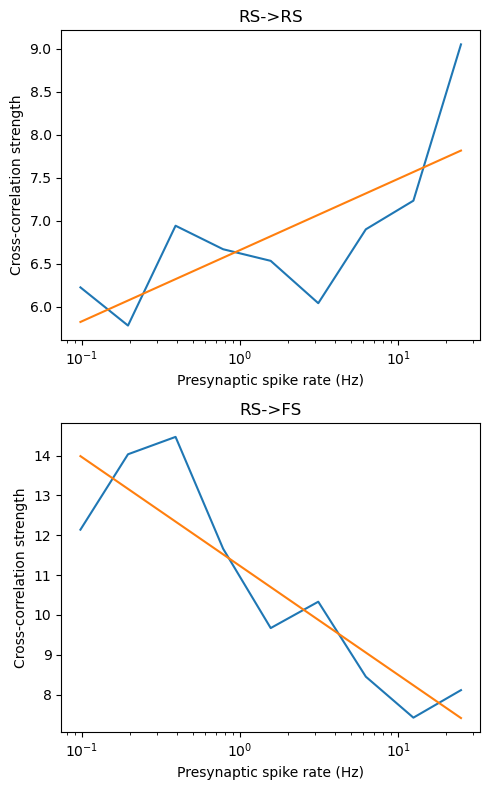

In [39]:
def strat_cc_str(cc_strat, isi_edges):
    # calculate cc strength from stratified cc
    cc_mean = cc_strat.mean(axis=1)
    cc_sort = cc_mean.sort_values(ascending=False)
    cc_peak_locs = cc_sort.index.values[:2]
    cc_str = np.mean(cc_strat.loc[cc_peak_locs].values, axis=0)
    
    # fit a line to the cc_str across presynaptic spike rate
    pre_rate = 1/np.array(isi_edges)
    fit_coefs = np.polyfit(np.log(pre_rate), cc_str, 1)

    return cc_str, fit_coefs

def plot_strat_cc(cc_str, fit_coefs, isi_edges, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(1/np.array(isi_edges), cc_str)
    ax.plot(1/np.array(isi_edges), np.polyval(fit_coefs, np.log(1/np.array(isi_edges))))
    ax.set_xscale('log')
    ax.set_xlabel('Presynaptic spike rate (Hz)')
    ax.set_ylabel('Cross-correlation strength')
    return ax
cc_str_rsrs, fit_coefs_rsrs = strat_cc_str(rs_rs_cc, isi_edges)
cc_str_rsfs, fit_coefs_rsfs = strat_cc_str(rs_fs_cc, isi_edges)

fig, ax = plt.subplots(2,1,figsize=(5,8))
plot_strat_cc(cc_str_rsrs, fit_coefs_rsrs, isi_edges, ax=ax[0])
ax[0].set_title('RS->RS')
plot_strat_cc(cc_str_rsfs, fit_coefs_rsfs, isi_edges, ax=ax[1])
ax[1].set_title('RS->FS')
fig.tight_layout()

fig.savefig("..\\figures\\grant\\cc_str_vs_rate_a1.pdf")


In [40]:
cc_sub = conn_cc.iloc[((conn_cc.index.get_level_values(1)=='RS->FS') & (conn_cc.index.get_level_values(2)==1)) |
                      ((conn_cc.index.get_level_values(1)=='RS->RS') & (conn_cc.index.get_level_values(2)==1))]

cc_sub = cc_sub.explode()
cc_sub = cc_sub.to_frame()
# get the pre_id from each row
cc_sub['pre_id'] = cc_sub.apply(lambda x: x[0][1], axis=1)
cc_sub['post_id'] = cc_sub.apply(lambda x: x[0][2], axis=1)

# calculate stratified cc for each connection
cc_strat = []
for row in cc_sub.iterrows():
    print(row)
    pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
    post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
    cc_strat.append(strat_cc(pre_spks, post_spks, isi_edges, reverse=True))



C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cc_sub['pre_id'] = cc_sub.apply(lambda x: x[0][1], axis=1)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cc_sub['post_id'] = cc_sub.apply(lambda x: x[0][2], axis=1)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated Num

((25, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.762283484919629, 1.754901088513622, 1.6800...
pre_id                                                                    236
post_id                                                                   211
Name: (25, RS->FS, 1.0), dtype: object)
((25, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.7880509310626442, 0.7159416955405723, 0.77...
pre_id                                                                    629
post_id                                                                   598
Name: (25, RS->FS, 1.0), dtype: object)
((25, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.6984084722995365, 1.9853017953231067, 1.70...
pre_id                                                                    636
post_id                                                                   598
Name: (25, RS->FS, 1.0), dtype: object)
((25, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.23566483580108, 1.3602483274764974, 1.2738...
pre_id      

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((25, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.9771576799791929, 1.238490547880605, 1.340...
pre_id                                                                    603
post_id                                                                   649
Name: (25, RS->RS, 1.0), dtype: object)
((25, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.7405408545570424, 1.856576911527512, 1.933...
pre_id                                                                    605
post_id                                                                   612
Name: (25, RS->RS, 1.0), dtype: object)
((25, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.2353781889636009, 1.2230858686754056, 1.26...
pre_id                                                                    607
post_id                                                                   649
Name: (25, RS->RS, 1.0), dtype: object)
((25, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.8209349564386417, 1.010381484847559, 0.820...
pre_id      

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Te

((75, 'RS->FS', 1.0), cc       pre_id  post_id    [[3.893934138604634, 3.993778603697061, 4.3199...
pre_id                                                                    315
post_id                                                                   742
Name: (75, RS->FS, 1.0), dtype: object)
((75, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.5977582702789674, 0.5631442056302968, 0.57...
pre_id                                                                    347
post_id                                                                   742
Name: (75, RS->FS, 1.0), dtype: object)
((75, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.6620998515360671, 0.6960536900763782, 0.56...
pre_id                                                                    496
post_id                                                                   598
Name: (75, RS->FS, 1.0), dtype: object)
((75, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.3661311125997799, 0.3857993128634044, 0.32...
pre_id      

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((75, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.6183888497357386, 1.4460888961517058, 1.44...
pre_id                                                                    756
post_id                                                                   598
Name: (75, RS->FS, 1.0), dtype: object)
((75, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.6039677846677416, 1.312337278364516, 1.324...
pre_id                                                                    633
post_id                                                                   694
Name: (75, RS->FS, 1.0), dtype: object)
((75, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.0783403159942675, 1.1677214651809582, 1.19...
pre_id                                                                    107
post_id                                                                   196
Name: (75, RS->RS, 1.0), dtype: object)
((75, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.678864466501351, 1.6545330974216215, 1.635...
pre_id      

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((75, 'RS->RS', 1.0), cc       pre_id  post_id    [[2.2321933472866964, 2.2627155899569793, 2.24...
pre_id                                                                    236
post_id                                                                   290
Name: (75, RS->RS, 1.0), dtype: object)
((75, 'RS->RS', 1.0), cc       pre_id  post_id    [[2.41352974665455, 2.4197662576278174, 2.1204...
pre_id                                                                    236
post_id                                                                   294
Name: (75, RS->RS, 1.0), dtype: object)
((75, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.8444821268309098, 1.0556026585386373, 0.84...
pre_id                                                                    527
post_id                                                                   475
Name: (75, RS->RS, 1.0), dtype: object)
((75, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.2695811135202555, 1.2309136684384203, 1.28...
pre_id      

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((125, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.0587606605665705, 1.1937007447564276, 1.10...
pre_id                                                                    314
post_id                                                                   211
Name: (125, RS->FS, 1.0), dtype: object)
((125, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.0831764637423091, 1.1030030034223142, 1.08...
pre_id                                                                    500
post_id                                                                   393
Name: (125, RS->FS, 1.0), dtype: object)
((125, 'RS->RS', 1.0), cc       pre_id  post_id    [[2.2970711449269396, 2.286907113312219, 2.388...
pre_id                                                                    185
post_id                                                                   290
Name: (125, RS->RS, 1.0), dtype: object)
((125, 'RS->RS', 1.0), cc       pre_id  post_id    [[2.2106972508356324, 2.192427025622115, 2.009...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Te

((175, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.8949034887136664, 1.8071087324798287, 1.92...
pre_id                                                                    185
post_id                                                                    29
Name: (175, RS->FS, 1.0), dtype: object)
((175, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.1123359807233253, 1.1181708380375632, 1.11...
pre_id                                                                    215
post_id                                                                   742
Name: (175, RS->FS, 1.0), dtype: object)
((175, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.8442500331525491, 0.7976518170369863, 0.79...
pre_id                                                                    421
post_id                                                                   694
Name: (175, RS->FS, 1.0), dtype: object)
((175, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.9723655462718985, 1.2880686457108266, 0.90...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Te

((175, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.5280535038765788, 1.4954839798152662, 1.56...
pre_id                                                                    163
post_id                                                                   290
Name: (175, RS->RS, 1.0), dtype: object)
((175, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.5803681039918556, 1.1523517424940615, 1.64...
pre_id                                                                    731
post_id                                                                   559
Name: (175, RS->RS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[2.7473063974625114, 3.208853872236213, 2.824...
pre_id                                                                      1
post_id                                                                    29
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.8863253003003275, 0.8441193336193595, 0.84...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.0147097727221184, 1.2794166699539753, 1.10...
pre_id                                                                    754
post_id                                                                   348
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[2.1012156675930407, 2.037348929976231, 1.947...
pre_id                                                                    433
post_id                                                                   748
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.6035875359571974, 1.4532512044612103, 1.75...
pre_id                                                                    435
post_id                                                                   748
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.4623971409780765, 1.4481066151704731, 1.43...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.0291207785499514, 1.0575052979017534, 1.06...
pre_id                                                                    467
post_id                                                                   748
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.2337447927771983, 1.182221125801949, 1.215...
pre_id                                                                    500
post_id                                                                   743
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.7107857138707283, 0.7281219507944047, 0.66...
pre_id                                                                    529
post_id                                                                   694
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.1132977167772513, 1.1319303145475819, 1.13...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.9942301534979839, 1.0644111055096064, 1.11...
pre_id                                                                    612
post_id                                                                   694
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[0.91344773628508, 1.0123117443281298, 1.0150...
pre_id                                                                    705
post_id                                                                   761
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.273573124722459, 1.1857404954312551, 1.202...
pre_id                                                                    726
post_id                                                                   761
Name: (250, RS->FS, 1.0), dtype: object)
((250, 'RS->FS', 1.0), cc       pre_id  post_id    [[1.1519881725441727, 1.1440214493592198, 1.15...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.1294751348879362, 1.0319664901494092, 1.17...
pre_id                                                                     57
post_id                                                                   139
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.6119846407638537, 0.7881620373473873, 0.77...
pre_id                                                                     94
post_id                                                                   198
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.8038474089353158, 1.8509906011908468, 1.90...
pre_id                                                                     94
post_id                                                                   290
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.422315072790659, 1.3361141592881947, 1.099...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.4788181142496853, 0.6384241523329137, 0.75...
pre_id                                                                    139
post_id                                                                   629
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.2770112615038935, 1.0033659911816306, 1.09...
pre_id                                                                    629
post_id                                                                   163
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.4086037680869734, 1.3729429131986957, 1.31...
pre_id                                                                    465
post_id                                                                   191
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.0004764180447951, 0.8858384951438291, 1.04...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
c:\Users\dbh60\.conda\envs\AudA

((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.8009621769872577, 0.8252337581080836, 0.82...
pre_id                                                                    731
post_id                                                                   216
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.3750078083200739, 1.3161389724898567, 1.34...
pre_id                                                                    290
post_id                                                                   500
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.3272462245700212, 0.3232796036661422, 0.32...
pre_id                                                                    526
post_id                                                                   290
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[3.1958218242229366, 3.595299552250804, 2.996...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.8369944982652969, 0.709856093465505, 0.836...
pre_id                                                                    383
post_id                                                                   500
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[2.81409150727901, 2.7413132786424836, 2.6927...
pre_id                                                                    383
post_id                                                                   599
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.462410442591448, 1.6212075361051657, 1.344...
pre_id                                                                    421
post_id                                                                   600
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.2377991278803842, 1.3839958752678314, 1.03...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Te

((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[0.06526742755220542, 0.04351161836813695, 0....
pre_id                                                                    732
post_id                                                                   596
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.2762163836596392, 1.2796287269314564, 1.34...
pre_id                                                                    606
post_id                                                                   664
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[2.287010058364229, 1.6476309022624014, 2.139...
pre_id                                                                    754
post_id                                                                   653
Name: (250, RS->RS, 1.0), dtype: object)
((250, 'RS->RS', 1.0), cc       pre_id  post_id    [[1.5457677364425284, 1.9951188226176821, 1.56...
pre_i

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pre_spks = spks[int(row[1]['pre_id'].values)].times() #[row[1]['pre_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\3845546506.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_spks = spks[int(row[1]['post_id'].values)].times() #[row[1]['post_id'].values]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\428125731.py:23: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  tsg = nap.TsGroup(tsg)
C:\Users\dbh60\AppData\Local\Te

In [41]:
cc_type = cc_sub.index.get_level_values(1)

cc_str = []
cc_coefs = []
for cc in cc_strat:
    print(cc)
    if len(cc)==0:
        cc_str.append(np.array([]))
        cc_coefs.append(np.array([]))
        continue
    stp_data = strat_cc_str(cc, isi_edges)
    cc_str.append(stp_data[0])
    cc_coefs.append(stp_data[1])

stp_df = pd.DataFrame({'type': cc_type, 'str': cc_str, 'coefs': cc_coefs})
stp_df

               10        11        12        13        14        15        16  \
                0         0         0         0         0         0         0   
-0.0100  1.761361  1.614889  1.622960  1.589404  1.544480  2.154187  4.140534   
-0.0095  1.596385  1.697281  1.707052  1.673057  1.507264  1.866962  1.840238   
-0.0090  1.640055  1.647846  1.437960  1.386247  1.525872  1.579737  3.220416   
-0.0085  1.581829  1.873051  1.665006  1.601354  1.898036  1.866962  1.610208   
-0.0080  1.572124  1.768688  1.732279  1.517701  1.283966  1.579737  2.070267   
-0.0075  1.557567  1.653338  1.589324  1.637205  1.358398  1.914833  3.220416   
-0.0070  1.562420  1.559960  1.765915  1.637205  1.656130  1.819091  2.070267   
-0.0065  1.610942  1.691788  1.690233  1.661106  1.767779  2.106316  1.840238   
-0.0060  1.431409  1.570946  1.791143  1.696957  1.693346  1.866962  2.530327   
-0.0055  1.475079  1.697281  1.698643  1.625255  1.749171  1.531866  3.220416   
-0.0050  1.431409  1.433626 

,type,str,coefs
0,RS->FS,"[1.5066189323513817, 1.5077786930611399, 1.665...","[-4.047632711655922, 8.275166913602797]"
1,RS->FS,"[1.707219846890722, 1.2556195011865894, 1.1013...","[0.007835278140017546, 1.588340762048719]"
2,RS->FS,"[23.787269166703066, 17.259284838462108, 14.57...","[2.242024791455857, 14.710294333870765]"
3,RS->FS,"[1.1922274851573564, 1.2226838045762243, 1.578...","[-1.8720068708197406, 4.479177576891354]"
4,RS->FS,"[1.1924218721944753, 0.9687792712751437, 0.874...","[-1.361106950139819, 3.301521641318318]"
...,...,...,...
105,RS->RS,"[1.568913386955289, 1.4860827453791765, 1.2997...","[-2.8450431379542467, 5.98017117901363]"
106,RS->RS,"[4.865056873796499, 3.389142496990935, 2.91414...","[-0.5310633520948611, 4.890412582115113]"
107,RS->RS,"[2.7680556656884776, 2.2137834926936186, 1.847...","[-0.10188808632108902, 2.3825302817079645]"
108,RS->RS,"[3.2186856547922478, 2.386447250769835, 1.6763...","[-0.014603653475487081, 2.07134382802862]"


In [42]:
strong_cc = stp_df['str'].apply(lambda x: np.mean(x))>4
print(strong_cc)
stp_df = stp_df.loc[strong_cc]
temp = stp_df['coefs'].loc[stp_df['type']=='RS->FS'].values

# convert temp to a nx2 array
coefs_rsfs = np.zeros((len(temp), 2))
for i, coef in enumerate(temp):
    try:
        coefs_rsfs[i] = coef
    except:
        coefs_rsfs[i] = np.array([np.nan, np.nan])

#np.concatenate(stp_df['coefs'].loc[stp_df['type']=='RS->FS'].values, axis=1)
temp = stp_df['coefs'].loc[stp_df['type']=='RS->RS'].values

# convert temp to a nx2 array
coefs_rsrs = np.zeros((len(temp), 2))
for i, coef in enumerate(temp):
    try:
        coefs_rsrs[i] = coef
    except:
        coefs_rsrs[i] = np.array([np.nan, np.nan])

0       True
1      False
2       True
3      False
4      False
       ...  
105     True
106     True
107    False
108    False
109    False
Name: str, Length: 110, dtype: bool


c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [95]:
np.vstack(stp_df['str'].loc[stp_df['type']=='RS->FS'].to_list()).T

array([[ 1.50661893, 23.78726917,  4.98853217,  1.51937558,  5.58292311,
        11.68221936,  2.65180739,  3.78196332,  7.17295517,  8.11116875],
       [ 1.50777869, 17.25928484,  3.70813617,  1.56755912,  5.31448708,
         7.21463775,  1.955664  ,  3.33536743,  3.13769362,  7.42048166],
       [ 1.66500604, 14.57342048,  3.65562908,  1.78803719,  5.32136962,
         7.39198409,  2.47498707,  3.79421149,  3.75045944,  8.44879361],
       [ 1.66110615, 17.97420031,  5.16198205,  2.26293773,  5.58140288,
        16.26824863,  3.7121676 ,  3.8037416 ,  4.91191758, 10.33015157],
       [ 1.8236034 , 19.00973875,  4.77360419,  2.33766074,  6.01980162,
        19.96222592,  4.77713067,  4.30710804,  7.47922725,  9.66892706],
       [ 1.89089732, 17.20293481,  5.91840682,  2.87621038,  5.50145964,
        23.61206752,  5.22775765,  5.22997029,  8.01652981, 11.65992506],
       [ 2.18528204, 15.86435053,  5.80815986,  2.95739788,  5.5725153 ,
        29.11856028,  4.17811346,  5.27949474

C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\323534994.py:2: RuntimeWarning: divide by zero encountered in divide
  rs_rs_str = rs_rs_str/rs_rs_str[0,:]
C:\Users\dbh60\AppData\Local\Temp\ipykernel_19644\323534994.py:2: RuntimeWarning: invalid value encountered in divide
  rs_rs_str = rs_rs_str/rs_rs_str[0,:]


(-1.0, 2.0)

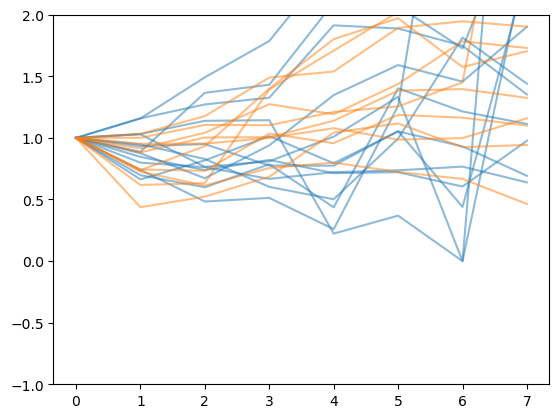

In [103]:
rs_rs_str = np.vstack(stp_df['str'].loc[stp_df['type']=='RS->RS'].to_list()).T
rs_rs_str = rs_rs_str/rs_rs_str[0,:]
rs_fs_str = np.vstack(stp_df['str'].loc[stp_df['type']=='RS->FS'].to_list()).T
rs_fs_str = rs_fs_str/rs_fs_str[0,:]
plt.plot(rs_rs_str[:-1,:], color='tab:blue', alpha=0.5)
plt.plot(rs_fs_str[:-1,:], color='tab:orange', alpha=0.5)
plt.ylim([-1, 2])

In [78]:
ind = 25
plt.plot(isi_edges,stp_df['str'].iloc[ind])
plt.xscale('log')
plt.title(stp_df['coefs'].iloc[ind])

IndexError: single positional indexer is out-of-bounds

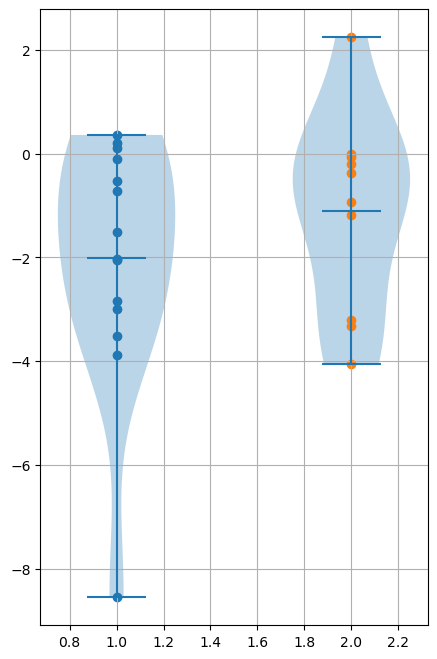

In [79]:
coefs_rsfs = coefs_rsfs[~np.isnan(coefs_rsfs).any(axis=1)]
coefs_rsrs = coefs_rsrs[~np.isnan(coefs_rsrs).any(axis=1)]
plt.figure(figsize=[5,8])
plt.violinplot([coefs_rsrs[:,0], coefs_rsfs[:,0]], showmeans=True)
plt.scatter(np.ones(coefs_rsrs.shape[0]), coefs_rsrs[:,0])
plt.scatter(np.ones(coefs_rsfs.shape[0])*2, coefs_rsfs[:,0])
plt.grid()


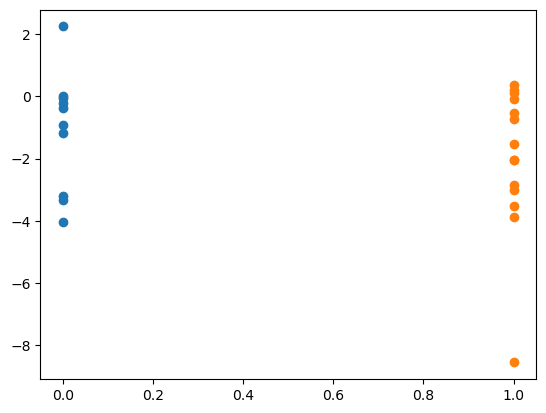

Now we can plot the connection matrix.

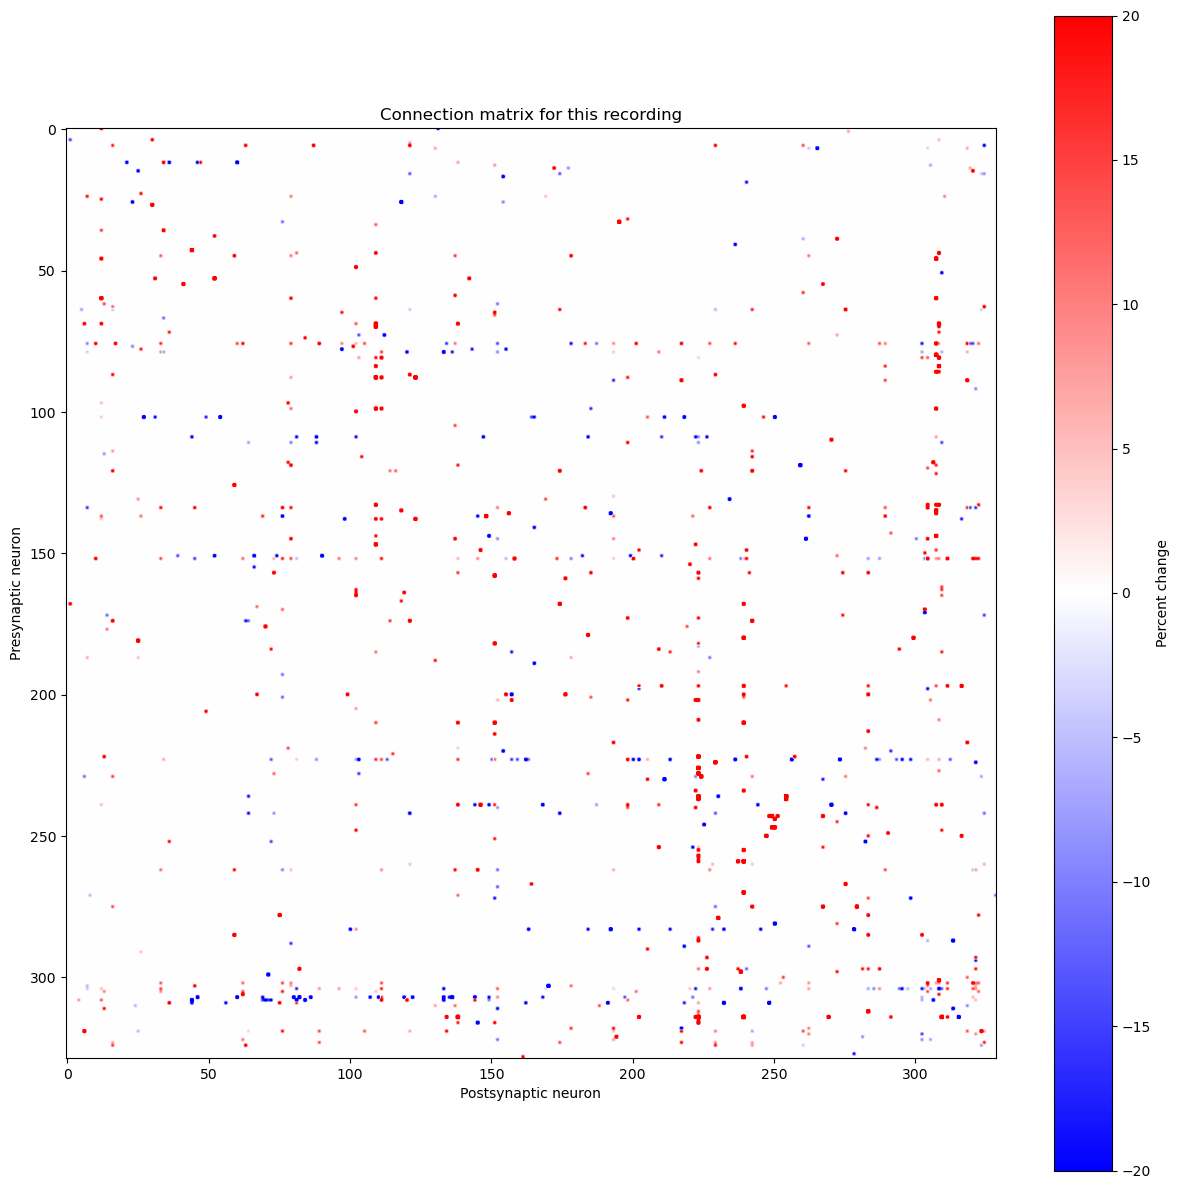

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
imh = ax.imshow(conn_mat.values,cmap='bwr', vmin=-20, vmax=20)
fig.colorbar(imh, label='Percent change')
ax.set_xlabel('Postsynaptic neuron')
ax.set_ylabel('Presynaptic neuron')
ax.set_title('Connection matrix for this recording')
ax.set_aspect('equal')
plt.show()

### Bring in unit properties and add them to pair dataframe

,halfwidth,firing_rate,peak,x,y,unit_type
cluster_id,,,,,,
1,0.213333,0.618804,-68.417289,27.0,3225.0,RS
2,0.233333,5.659228,-23.013167,27.0,3255.0,RS
5,0.233333,0.105429,-25.890844,309.0,3240.0,RS
6,0.236667,0.234809,-29.162822,309.0,3255.0,RS
8,0.143333,9.919040,-25.496567,277.0,3225.0,FS
...,...,...,...,...,...,...
761,0.116667,10.637017,-19.652656,527.0,3300.0,FS
763,0.136667,17.179659,-21.245256,527.0,3615.0,FS
764,0.093333,10.124531,-25.581856,809.0,3630.0,FS


In [23]:
sig_df

,w,cc
pair,,
"(754, 598)",418.537859,"[0.7373272935840243, 0.7472911759297544, 0.827..."
"(562, 554)",306.616990,"[1.2544227571469853, 1.2888314910937717, 1.320..."
"(754, 356)",277.287762,"[0.9087535068446069, 0.804739551241911, 0.8156..."
"(590, 624)",240.789474,"[1.4871484369632368, 1.159100987633111, 1.1809..."
"(754, 748)",225.363825,"[1.7083848910019743, 1.7358288249939737, 1.598..."
...,...,...
"(754, 755)",-76.785714,"[3.670438339626864, 3.0281116301921625, 2.3857..."
"(598, 656)",-80.835381,"[1.8342430898637614, 1.6890321785828801, 1.796..."
"(565, 527)",-86.206897,"[0.749513057021262, 0.7182833463120428, 0.8744..."
